<a href="https://www.kaggle.com/code/davidfmora/assign3" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Assignment 3**

Eduards Mendez

David Mora

**Nota**: This notebook is ment to be run in Kaggle, for doing so press the button in the top left corner with the label of the notebook named: `Open in Kaggle`.

In [1]:
!pip install -q evaluate

In [2]:
import json
import os

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.nn.functional import one_hot
from tqdm import tqdm
import evaluate
import transformers
from transformers import (
    TrainingArguments,
    ViTFeatureExtractor,
    ViTForImageClassification,
    ConvNextFeatureExtractor,
    ConvNextForImageClassification,
    Trainer,
)
import pandas as pd
from pprint import pprint
from random import randint
import wandb


wandb.login(key="5f5a6e6618ddafd57c6c7b40a8313449bfd7a04e")
Image.MAX_IMAGE_PIXELS = (
    None  # disable the pixel limit so no DecompressionBombWarning is triggered
)
sigmoid = lambda x: 1 / (1 + np.exp(-x))


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# **Data exploration**

Our dataset consist of movie posters images along with their genres and more information. We will first explore the dataset, which is located in: `/kaggle/input/raw-mmimdb/mmimdb/dataset/`

In [3]:
ds_path = "/kaggle/input/raw-mmimdb/mmimdb/dataset/"
ids = [x.split(".")[0] for x in os.listdir(ds_path) if x.endswith(".jpeg")]
print("Some image ids:", ids[:5])


Some image ids: ['0056049', '0039288', '3010660', '0095927', '1343115']


This is and example image and its genres:

Genres: ['Drama']


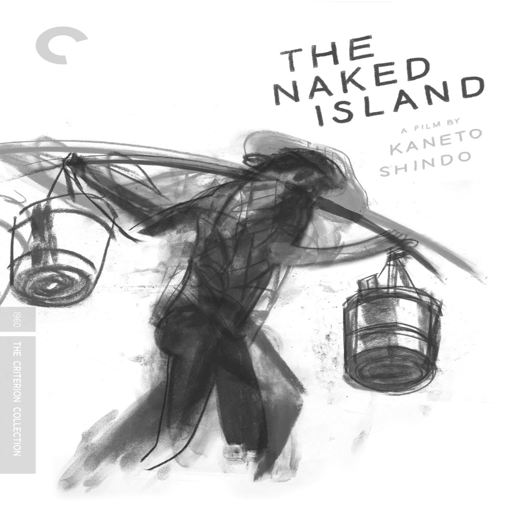

In [4]:
img = f"{ds_path}{ids[0]}.jpeg"
metadata_file = f"{ds_path}{ids[0]}.json"

with open(metadata_file, "r") as f:
    metadata = json.load(f)
print("Genres:", metadata["genres"])
Image.open(img).resize((512, 512))


Unique genres and mapping from genres names to index labels:

In [5]:
unique_genres = [
    "Action",
    "Adult",
    "Adventure",
    "Animation",
    "Biography",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Family",
    "Fantasy",
    "Film-Noir",
    "History",
    "Horror",
    "Music",
    "Musical",
    "Mystery",
    "News",
    "Reality-TV",
    "Romance",
    "Sci-Fi",
    "Short",
    "Sport",
    "Talk-Show",
    "Thriller",
    "War",
    "Western",
]
label_to_string = {l: s for l, s in enumerate(unique_genres)}
string_to_label = {s: l for l, s in label_to_string.items()}


Now we retrive the image ids for the 3 data splits, namely training, validation and testing:

In [6]:
with open("/kaggle/input/raw-mmimdb/mmimdb/split.json", "r") as f:
    split_json = json.load(f)
train, val, test = split_json["train"], split_json["dev"], split_json["test"]
print("Sample in Train split:     ", len(train))
print("Sample in Validation split:", len(val))
print("Sample in Test split:      ", len(test))


Sample in Train split:      15552
Sample in Validation split: 2608
Sample in Test split:       7799


For each split we will count the classes present in it to get a sense of the distribution of the genres:

In [7]:
def count_classes(split_ids):
    """Counts the number of samples for each class in the split."""

    class_counts = [0 for _ in range(len(unique_genres))]
    for id in tqdm(split_ids):
        metadata_file = ds_path + id + ".json"
        with open(metadata_file, "r") as f:
            metadata = json.load(f)
        genres = metadata["genres"]
        for genre in genres:
            label = string_to_label[genre]
            class_counts[label] += 1
    return class_counts


In [8]:
train_counts = count_classes(train)
val_counts = count_classes(val)
test_counts = count_classes(test)


100%|██████████| 7799/7799 [00:43<00:00, 180.89it/s]


We get the proportions instead of the raw counts:

In [9]:
train_props = [c / sum(train_counts) for c in train_counts]
val_props = [c / sum(val_counts) for c in val_counts]
test_props = [c / sum(test_counts) for c in test_counts]


En la siguiente grafica se muestran las proporciones de las clases en cada split.
In the next plot we show the proporttions of the classes in each split, from this we can extract the following insights:
- The proportions for each dataset are roughly stratified.
- The genres `Adult`, `Reality-TV`, `Talk-show` and `News` are almost all negative samples.

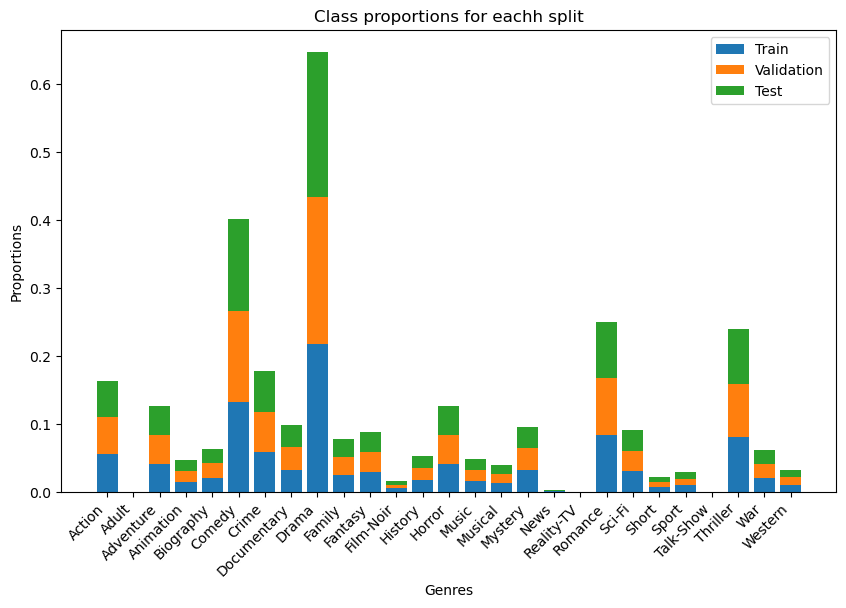

In [10]:
x = np.arange(len(unique_genres))
plt.figure(figsize=(10, 6))

bar1 = plt.bar(x, train_props, label="Train")
bar2 = plt.bar(x, val_props, bottom=train_props, label="Validation")
bar3 = plt.bar(
    x, test_props, bottom=np.array(train_props) + np.array(val_props), label="Test"
)

plt.xticks(x, unique_genres, rotation=45, ha="right")
plt.xlabel("Genres")
plt.ylabel("Proportions")
plt.title("Class proportions for eachh split")
plt.legend()

plt.show()


We will exlude this genres for computing the metrics later on:

In [11]:
excluded_genres = ["Talk-Show", "News", "Adult", "Reality-TV"]
included_labels = [
    label for string, label in string_to_label.items() if string not in excluded_genres
]


# **Prepare datasets**

Now we create the dataset classes for each dataset split:

In [12]:
def make_ds(split_ids: list) -> datasets.Dataset:
    """Makes a datasets.Dataset given the image ids."""

    img_paths = [ds_path + x + ".jpeg" for x in split_ids]
    ds_labels = []
    for id in tqdm(split_ids, desc="Collecting Genres"):
        metadata_file = ds_path + id + ".json"
        with open(metadata_file, "r") as f:
            metadata = json.load(f)
        genres = metadata["genres"]
        labels = [string_to_label[genre] for genre in genres]
        ds_labels.append(labels)

    data = {"image": img_paths, "labels": ds_labels}
    ds = datasets.Dataset.from_dict(data).cast_column("image", datasets.Image())
    return ds


train_ds = make_ds(train)
val_ds = make_ds(val)
test_ds = make_ds(test)


In [13]:
train_ds, val_ds, test_ds


(Dataset({
     features: ['image', 'labels'],
     num_rows: 15552
 }),
 Dataset({
     features: ['image', 'labels'],
     num_rows: 2608
 }),
 Dataset({
     features: ['image', 'labels'],
     num_rows: 7799
 }))

We now create a transform function that will take a batch of examples, apply the feature extrator of the correspoding model and also convert the labels to one hot encoding:

In [14]:
def transform_ft(feature_extractor):
    def transform(batch: dict):
        # preprocess images with feature extractor
        images = [image.convert("RGB") for image in batch["image"]]
        inputs = feature_extractor(images, return_tensors="pt")
        # labels converted to ohe and aggregated
        labels = []
        for label in batch["labels"]:
            label_pt = torch.tensor(label)
            ohe_vectors = one_hot(label_pt, num_classes=len(unique_genres))
            ohe_labels = ohe_vectors.sum(axis=0)
            labels.append(ohe_labels)
        inputs["labels"] = labels

        return inputs

    return transform


# **ViT model**

Now everything is almost ready to train our first model, the ViT model pretrained from Google:

We transform the dataset splits using the transform function from before and the ViT's feature extractor:

In [15]:
vit_model_name = "google/vit-base-patch16-224-in21k"
vit_feature_extractor = ViTFeatureExtractor.from_pretrained(vit_model_name)

vit_transform = transform_ft(vit_feature_extractor)

train_ds_vit = train_ds.with_transform(vit_transform)
val_ds_vit = val_ds.with_transform(vit_transform)
test_ds_vit = test_ds.with_transform(vit_transform)

print(train_ds_vit[:2].keys())
print(train_ds_vit[:2]["pixel_values"].shape)


dict_keys(['pixel_values', 'labels'])
torch.Size([2, 3, 224, 224])


/opt/conda/lib/python3.7/site-packages/transformers/models/vit/feature_extraction_vit.py:31: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  FutureWarning,


We also need to define the collate function for the data loading stage, this function with take a batch of examples and make them a tensor batch

In [16]:
def collate_fn(batch):
    return {
        "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
        "labels": torch.stack([x["labels"] for x in batch]).float(),
    }


z = collate_fn([train_ds_vit[i] for i in range(3)])
print(
    "Pixel values shape:",
    list(z["pixel_values"].shape),
    "  Dtype:",
    z["pixel_values"].dtype,
)
print(
    "Labels shape:      ",
    list(z["labels"].shape),
    "           Dtype:",
    z["labels"].dtype,
)


Pixel values shape: [3, 3, 224, 224]   Dtype: torch.float32
Labels shape:       [3, 27]            Dtype: torch.float32


We also need to compute the metrics according to the paper [Gated Multimodal Units for Information Fusion
](https://arxiv.org/abs/1702.01992). This are variants of the F1 score suited for the task of multilabel multiclass classification, this are the sample, micro, macro and weighted f1 variants. Luckily this are alredy implemented in the library `evaluate` from HuggingFace.

In [17]:
def compute_metrics(pred_output: transformers.trainer_utils.PredictionOutput):
    preds_logits = pred_output.predictions
    preds = sigmoid(preds_logits).round().astype(np.int32)
    refs = pred_output.label_ids.astype(np.int32)

    metrics = {}
    f1_metric = evaluate.load("f1", config_name="multilabel")
    average_types = ["samples", "micro", "macro", "weighted"]
    for average_type in average_types:
        score = f1_metric.compute(
            predictions=preds,
            references=refs,
            average=average_type,
            labels=included_labels,
        )["f1"]
        metrics[f"f1_{average_type}"] = score
    return metrics


Now we are ready to initialize the model from the pretrained checkpoint, we also specify the task, which is `multi_label_classification`.

In [18]:
vit_model = ViTForImageClassification.from_pretrained(
    vit_model_name,
    num_labels=len(unique_genres),
    problem_type="multi_label_classification",
    id2label={str(i): c for i, c in label_to_string.items()},
    label2id={c: str(i) for i, c in string_to_label.items()},
)


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We pass create the training configuration that specifies the hyperparameters of the training loop and of the model.

In [19]:
training_args = TrainingArguments(
    output_dir="./vit-mmimdb",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",
    num_train_epochs=3,
    fp16=True,
    save_steps=600,
    eval_steps=200,
    logging_steps=20,
    learning_rate=2e-4,
    save_total_limit=5,
    remove_unused_columns=False,
    push_to_hub=False,
    dataloader_num_workers=os.cpu_count(),
    report_to="wandb",
    load_best_model_at_end=True,
)


In [20]:
trainer_vit = Trainer(
    model=vit_model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_ds_vit,
    eval_dataset=val_ds_vit,
    tokenizer=vit_feature_extractor,
)


Now we train the model and log the results in Weights and Biases:

In [21]:
train_results = trainer_vit.train()
trainer_vit.save_model()
trainer_vit.log_metrics("train", train_results.metrics)
trainer_vit.save_metrics("train", train_results.metrics)
trainer_vit.save_state()


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
wandb: Currently logged in as: dmorara. Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,F1 Samples,F1 Micro,F1 Macro,F1 Weighted
200,0.235200,0.233392,0.327533,0.319591,0.052558,0.216812
400,0.216900,0.220259,0.359393,0.360358,0.092671,0.253279
600,0.195000,0.216363,0.409627,0.412755,0.160338,0.339358


/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


***** train metrics *****
  epoch                    =          3.0
  total_flos               = 3367919823GF
  train_loss               =       0.2293
  train_runtime            =   0:35:54.59
  train_samples_per_second =       21.654
  train_steps_per_second   =        0.338


Now we evaluate the model in the testing split, we calculate the metrics and plot some predictions:

In [22]:
pred_output = trainer_vit.predict(test_ds_vit)


We print the metrics on the test dataset. Comparing with the results form the paper we can see that the scores that we obtained(using only images) are comparable to those of the Visual modality in the paper. On the other hand, the result are way begin the ones of the Textual and Multimodal(text + images) modalities.

In [23]:
print("Metrics on test dataset")
metrics = pred_output.metrics
pd.DataFrame(metrics, index=["Test"])


Metrics on test dataset


,test_loss,test_f1_samples,test_f1_micro,test_f1_macro,test_f1_weighted,test_runtime,test_samples_per_second,test_steps_per_second
Test,0.215252,0.403022,0.408889,0.161295,0.337009,286.0745,27.262,0.426


![paper-results](https://imgur.com/ZLyoc45.png)

Now we randomly select 5 samples from the test dataset, and display the corresponding images, and print the predicted and true genres for each selected sample.

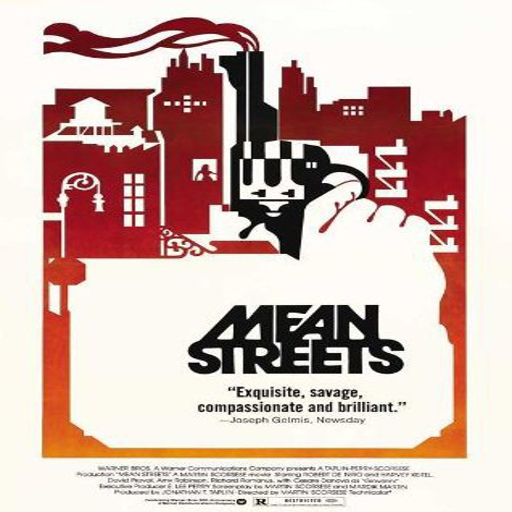

Predicted genres: ['Drama']
True genres: ['Crime', 'Drama', 'Romance', 'Thriller']


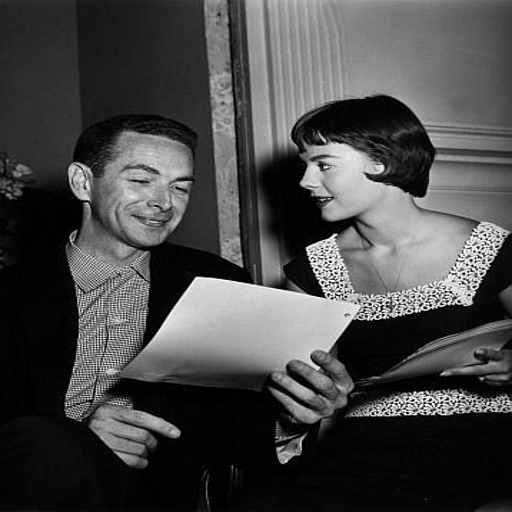

Predicted genres: ['Drama']
True genres: ['Comedy', 'Drama']


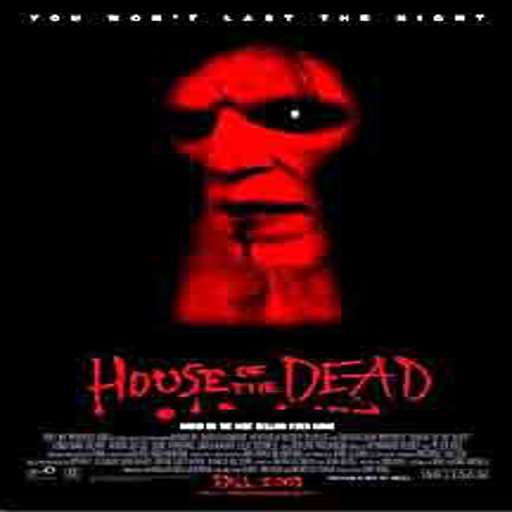

Predicted genres: ['Horror', 'Thriller']
True genres: ['Adventure', 'Horror']


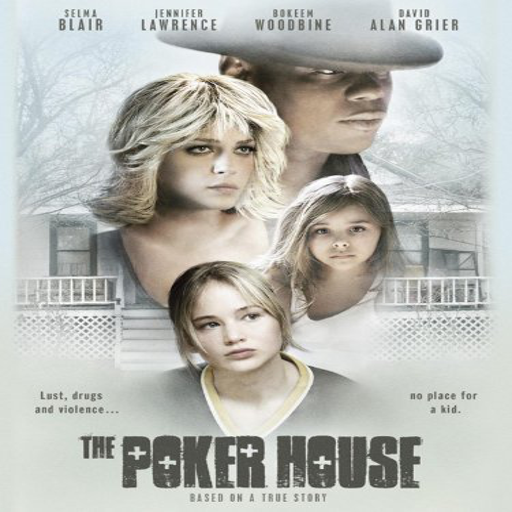

Predicted genres: ['Drama']
True genres: ['Drama']


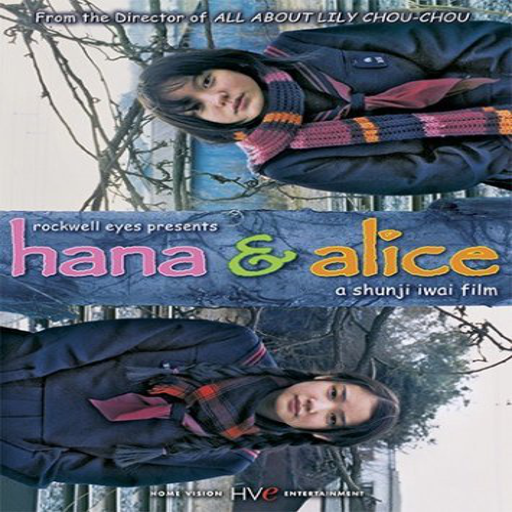

Predicted genres: []
True genres: ['Drama', 'Comedy']


In [24]:
preds_logits = pred_output.predictions
labels = pred_output.label_ids.astype(np.int32)
preds = sigmoid(preds_logits).round().astype(np.int32)

random_sample = [randint(0, len(test_ds)) for _ in range(5)]
for idx in random_sample:
    pred_labels = [idx for idx, x in enumerate(preds[idx].tolist()) if x == 1]
    pred_names = [label_to_string[label] for label in pred_labels]
    target_names = [label_to_string[label] for label in test_ds[idx]["labels"]]
    image = test_ds[idx]["image"].resize((512, 512))

    display(image)
    print("Predicted genres:", pred_names)
    print("True genres:", target_names)


# **ConvNeXT**

Now we will train the ConvNext model, it is the same procedure as before

In [25]:
convnext_model_name = "facebook/convnext-tiny-224"
convnext_feature_extractor = ConvNextFeatureExtractor.from_pretrained(
    convnext_model_name
)
convnext_transform = transform_ft(convnext_feature_extractor)

train_ds_convnext = train_ds.with_transform(convnext_transform)
val_ds_convnext = val_ds.with_transform(convnext_transform)
test_ds_convnext = test_ds.with_transform(convnext_transform)

convnext_model = ConvNextForImageClassification.from_pretrained(
    convnext_model_name,
    num_labels=len(unique_genres),
    problem_type="multi_label_classification",
    ignore_mismatched_sizes=True,
    id2label={str(i): c for i, c in label_to_string.items()},
    label2id={c: str(i) for i, c in string_to_label.items()},
)


/opt/conda/lib/python3.7/site-packages/transformers/models/convnext/feature_extraction_convnext.py:31: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  FutureWarning,


Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([27, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([27]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
training_args = TrainingArguments(
    output_dir="./convnext-mmimdb",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",
    num_train_epochs=3,
    fp16=True,
    save_steps=600,
    eval_steps=200,
    logging_steps=20,
    learning_rate=2e-4,
    save_total_limit=5,
    remove_unused_columns=False,
    push_to_hub=False,
    dataloader_num_workers=os.cpu_count(),
    report_to="wandb",
    load_best_model_at_end=True,
)


In [27]:
trainer_convnext = Trainer(
    model=convnext_model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_ds_convnext,
    eval_dataset=val_ds_convnext,
    tokenizer=convnext_feature_extractor,
)


In [28]:
train_results = trainer_convnext.train()
trainer_convnext.save_model()
trainer_convnext.log_metrics("train", train_results.metrics)
trainer_convnext.save_metrics("train", train_results.metrics)
trainer_convnext.save_state()


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,F1 Samples,F1 Micro,F1 Macro,F1 Weighted
200,0.224500,0.223877,0.351047,0.355705,0.097382,0.256843
400,0.210200,0.212812,0.413354,0.415221,0.149494,0.322089
600,0.192800,0.209728,0.424988,0.435359,0.186833,0.366474


/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


***** train metrics *****
  epoch                    =          3.0
  total_flos               = 1092595240GF
  train_loss               =       0.2178
  train_runtime            =   0:35:55.75
  train_samples_per_second =       21.643
  train_steps_per_second   =        0.338


In [29]:
pred_output = trainer_convnext.predict(test_ds_convnext)


Now we see the results for the evaluation in the test split. As well as the ViT the results are comprable with the paper results for the Visual modality but far inferior in comparison to the Multimodal modality. We can also observe that the results are slightly better than the ones from the ViTs, but the improvement is clearly not significant.

In [30]:
print("Metrics on test dataset")
metrics = pred_output.metrics
pd.DataFrame(metrics, index=["Test"])


Metrics on test dataset


,test_loss,test_f1_samples,test_f1_micro,test_f1_macro,test_f1_weighted,test_runtime,test_samples_per_second,test_steps_per_second
Test,0.209928,0.423435,0.434265,0.191074,0.368358,288.3056,27.051,0.423


![paper-results](https://imgur.com/ZLyoc45.png)

Predicted genres: ['Drama']
True genres: ['Crime', 'Drama', 'Romance', 'Thriller']


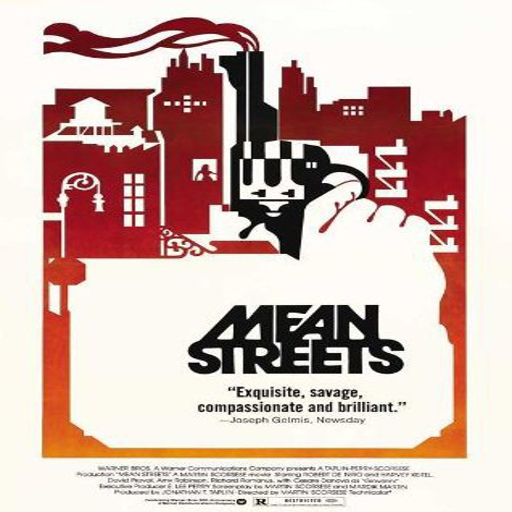

Predicted genres: ['Drama']
True genres: ['Comedy', 'Drama']


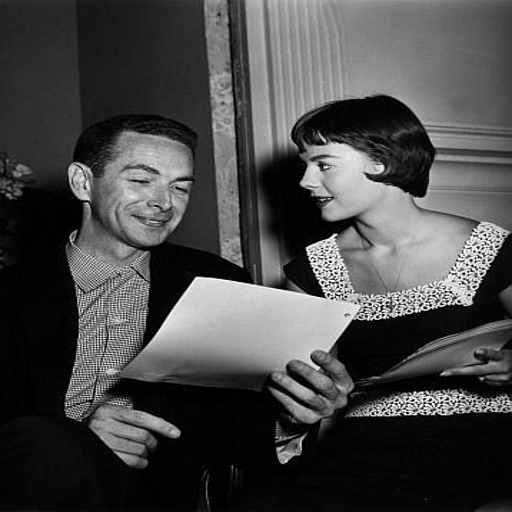

Predicted genres: ['Drama', 'Thriller']
True genres: ['Adventure', 'Horror']


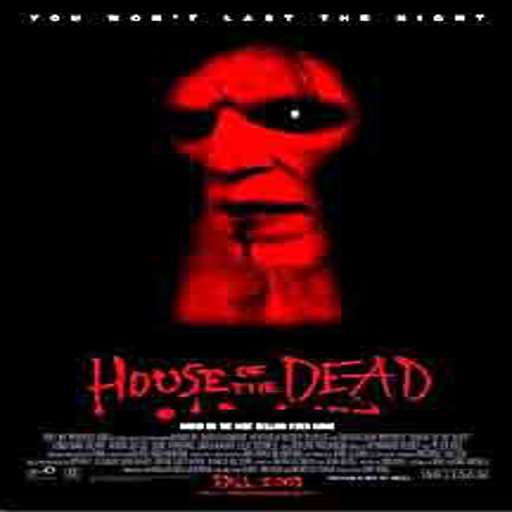

Predicted genres: ['Drama']
True genres: ['Drama']


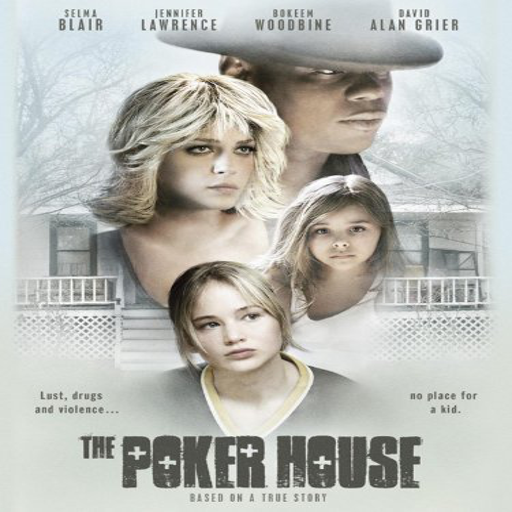

Predicted genres: ['Drama']
True genres: ['Drama', 'Comedy']


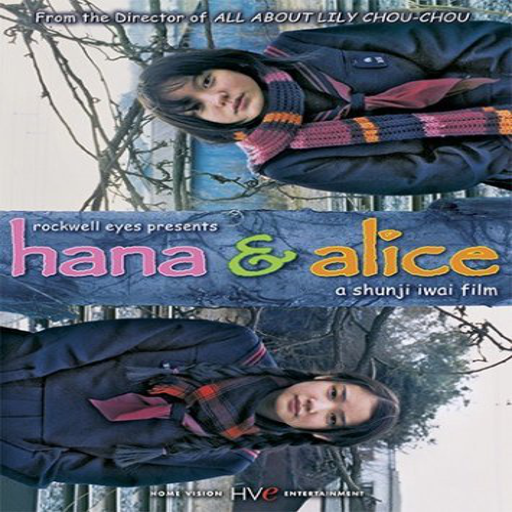

In [31]:
preds_logits = pred_output.predictions
labels = pred_output.label_ids.astype(np.int32)
preds = sigmoid(preds_logits).round().astype(np.int32)

random_sample = [randint(0, len(test_ds)) for _ in range(5)]
for idx in random_sample:
    pred_labels = [idx for idx, x in enumerate(preds[idx].tolist()) if x == 1]
    pred_names = [label_to_string[label] for label in pred_labels]
    target_names = [label_to_string[label] for label in test_ds[idx]["labels"]]
    image = test_ds[idx]["image"].resize((512, 512))

    print("Predicted genres:", pred_names)
    print("True genres:", target_names)
    display(image)


# **CLIP Model**

In [32]:
from transformers import AutoProcessor, CLIPModel

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.cuda()


In [33]:
batch_size = 20


def evaluate_ds(ds):
    ds_preds_ohe = []
    ds_targets_ohe = []

    for idx in tqdm(range(len(ds) // batch_size), desc="Evaluating ..."):
        inputs = clip_processor(
            text=[f"This movie has the genre {genre}" for genre in unique_genres],
            images=ds[batch_size * idx : batch_size * (idx + 1)]["image"],
            return_tensors="pt",
            padding=True,
        )
        for key in inputs.keys():
            inputs[key] = inputs[key].cuda()

        outputs = clip_model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)
        preds_labels = torch.topk(probs, 5).indices
        pred_ohe = torch.stack(
            [one_hot(p, num_classes=len(unique_genres)).sum(0) for p in preds_labels]
        )

        targets = ds[batch_size * idx : batch_size * (idx + 1)]["labels"]
        targets_ohe = torch.stack(
            [
                one_hot(torch.tensor(p), num_classes=len(unique_genres)).sum(0)
                for p in targets
            ]
        )

        ds_preds_ohe.append(pred_ohe)
        ds_targets_ohe.append(targets_ohe)

    preds = torch.vstack(ds_preds_ohe).cpu().numpy()
    refs = torch.vstack(ds_targets_ohe).cpu().numpy()

    metrics = {}
    f1_metric = evaluate.load("f1", config_name="multilabel")
    average_types = ["samples", "micro", "macro", "weighted"]
    for average_type in average_types:
        score = f1_metric.compute(
            predictions=preds,
            references=refs,
            average=average_type,
            labels=included_labels,
        )["f1"]
        metrics[f"f1_{average_type}"] = score

    return pd.DataFrame(metrics, index=["Test"])


We now evaluate the model in the training split:

In [34]:
evaluate_ds(train_ds)


Evaluating ...: 100%|██████████| 777/777 [18:38<00:00,  1.44s/it]


,f1_samples,f1_micro,f1_macro,f1_weighted
Test,0.354086,0.361856,0.315661,0.426437


And now in the test split:

In [35]:
evaluate_ds(test_ds)


Evaluating ...: 100%|██████████| 389/389 [08:54<00:00,  1.37s/it]


,f1_samples,f1_micro,f1_macro,f1_weighted
Test,0.352755,0.360582,0.314482,0.426315
